In [87]:
import os
from os.path import abspath, dirname
import shutil as sh
import re
from io import StringIO
import string
from icecream import ic
import fitz
import pytesseract

from PIL import Image
from PIL import ImageFilter
from matplotlib import pyplot as plt 
import numpy as np
import cv2
import pandas as pd
from collections import defaultdict, Counter
import statistics

## Image extraction from PDF 

In [139]:
def extract_img(file_name, save_img):
    sh.rmtree(save_img)  # delete this folder
    # if file don't exist, then create
    try:
        os.makedirs(save_img)
    except:
        print ("Directory already exist.")

    img_count = 0
    file_name1, _ = os.path.splitext(file_name)
    absolute_path = os.path.join(folder_path, file_name)

    doc = fitz.open(absolute_path)  # Document('.pdf')
    lenXREF = doc.xref_length()  # the number of entries in the xref table (cross-reference number)
    print(f'file name: {file_name}, the number of pages: {len(doc)}, length of xref table: {lenXREF - 1}')

    # extract images from each pages
    for idx, page in enumerate(doc): 
        imgs_list = page.get_images()  # the number of images in each page  
        for i in imgs_list:
            single_img = list(i)  # tuple -> list          
            xref = single_img[0]   
            img = doc.extract_image(xref)  # get image info

            # delete too small images, that may not be a chart
            pix = fitz.Pixmap(doc, xref)
            if pix.size < 10000: continue 
            img_count += 1

            # add images into folder
            img_name = f'{img_count}_p{idx+1}.' + img["ext"]  
            img_name = file_name1 + "_" + img_name
            img_path = os.path.join(save_img, img_name)   
            
            img_out = open(img_path, 'wb')   
            img_out.write(img["image"])   
            img_out.close

    print(f'Extraction finished. Total images: {img_count}')


file_name = 'sample5.pdf'
folder_path = abspath(dirname(file_name))  # get the direction
save_img = folder_path + '/imagesss'

extract_img(file_name, save_img)

file name: sample5.pdf, the number of pages: 54, length of xref table: 1326
Extraction finished. Total images: 4


## Applying image preprocessing (sometimes result is better)

Sharpening image

Text(0.5, 1.0, 'Kernel2')

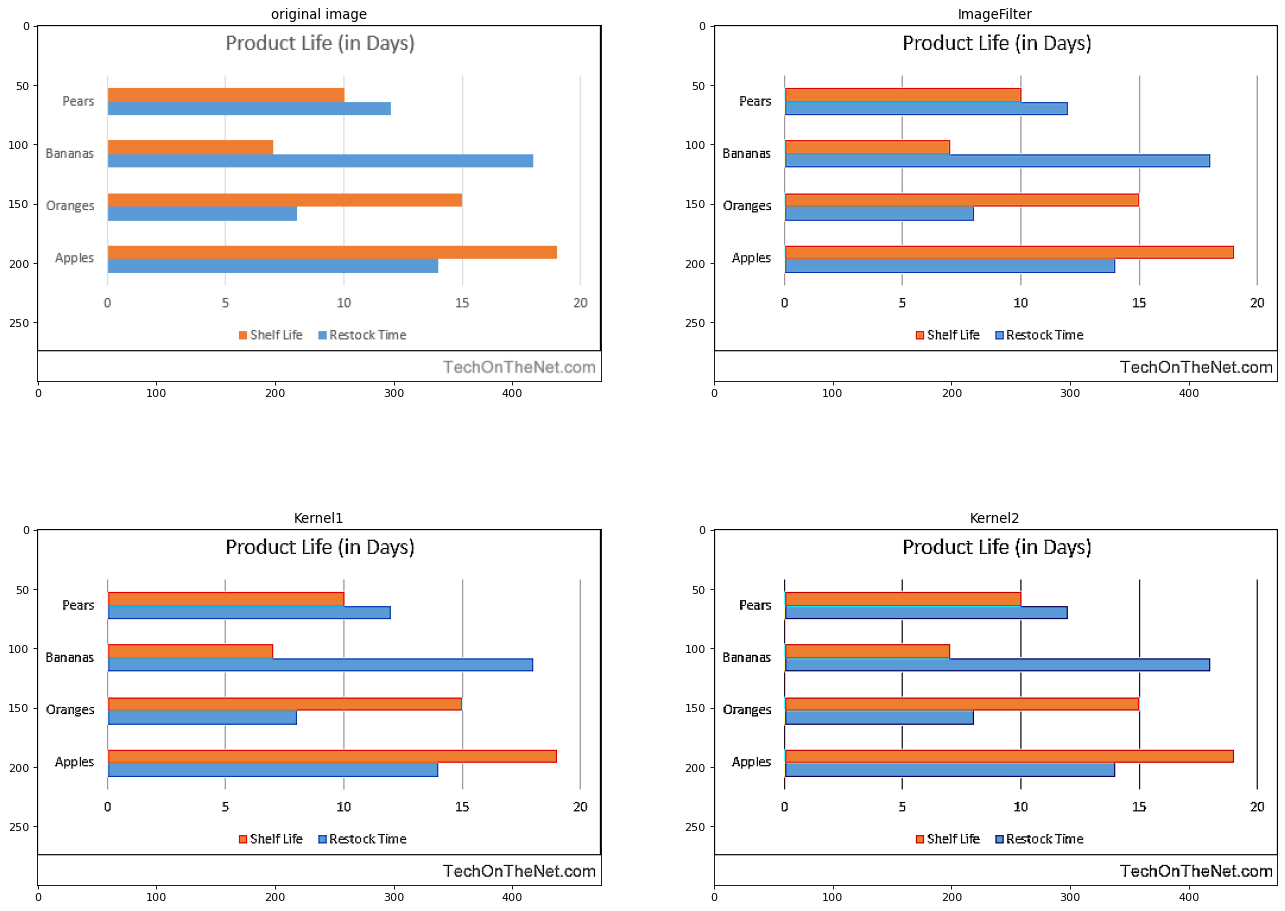

In [2]:
def cv2_PIL(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img


def kernel_PIL(original_img, kernel):
    img = cv2.filter2D(original_img, -1, kernel)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img


original_img = cv2.imread('horizontal_bar_chart.png')

img1 = cv2_PIL(original_img)
img2 = img1.filter(ImageFilter.SHARPEN)
img2 = img2.filter(ImageFilter.SHARPEN)

kernel1 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  
kernel2 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img3 = kernel_PIL(original_img, kernel1)
img4 = kernel_PIL(original_img, kernel2)

figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15), dpi=80)
ax[0][0].imshow(img1)
ax[0][0].set_title('original image')
ax[0][1].imshow(img2)
ax[0][1].set_title('ImageFilter')
ax[1][0].imshow(img3)
ax[1][0].set_title('Kernel1')
ax[1][1].imshow(img4)
ax[1][1].set_title('Kernel2')

In [3]:
# eliminate noise
def img_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1]  # > threshold 120, set it to maxval 255 white, otherwise 0 black
    image = cv2.GaussianBlur(image, (1, 1), 0)  # Gaussian Smoothing
    return image


# using PIL show image
def Image_show(original_img, image):
    img_cvt1 = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_cvt1 = Image.fromarray(img_cvt1)
    img_cvt2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cvt2 = Image.fromarray(img_cvt2)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
    ax[0].imshow(img_cvt1)
    ax[1].imshow(img_cvt2)


# using cv2 show image
def show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

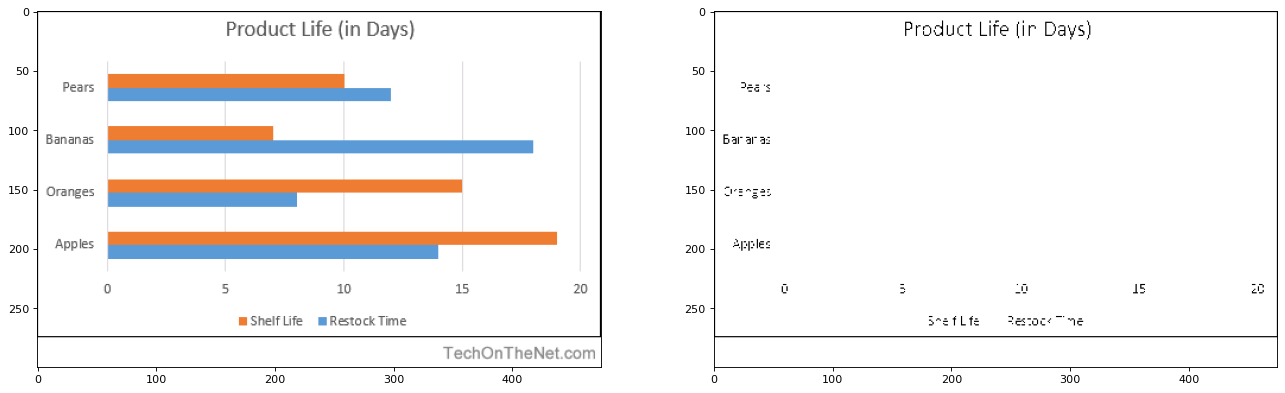

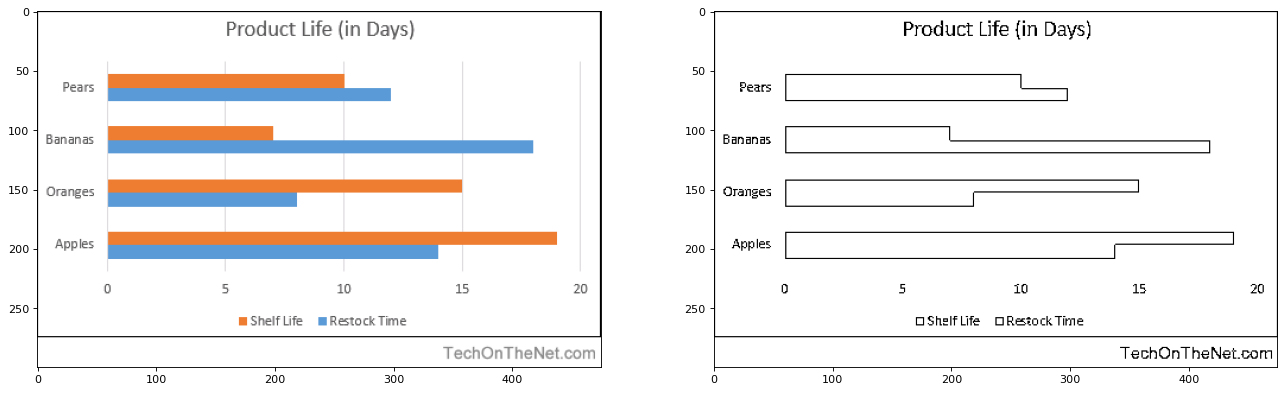

In [4]:
def img_pre(original_img, img4):
    # using original image
    img = img_preprocessing(original_img)
    Image_show(original_img, img)

    # using sharpened image
    img = cv2.cvtColor(np.array(img4), cv2.COLOR_RGB2BGR)
    img = img_preprocessing(img)
    Image_show(original_img, img)


img_pre(original_img, img3)

## Extracting coordinate system info

In [13]:
def text_extraction(original_img, sharpened_img, flag):
    if flag == 0: 
        img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  
    elif flag == 1:
        img_pre = img_preprocessing(original_img)
        img_rgb = cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB)  
    elif flag == 2:
        img_rgb = sharpened_img
    elif flag == 3:
        img = cv2.cvtColor(np.array(sharpened_img), cv2.COLOR_RGB2BGR)
        img = img_preprocessing(img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    data = pytesseract.image_to_data(img_rgb)
    # convert to dataframe and delete nan values and blank spaces
    df = pd.read_csv(StringIO(data), sep='\t')
    df.dropna(inplace=True)
    df = df[~df['text'].isin([' ','  ','   '])]
    df = df.reset_index().drop(labels='index', axis=1)

    return df

# 0: original image, 1: original image with image processing, 2: sharpened image, 3: sharpened image with image processing
df = text_extraction(original_img, img3, 2)
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,3,1,1,1,22,60,26,8,95.782410,Pears
1,5,1,4,1,1,1,8,104,40,8,94.580330,Bananas
2,5,1,5,1,1,1,8,148,40,10,89.077652,Oranges
3,5,1,6,1,1,1,15,192,33,10,89.718781,Apples
4,5,1,7,1,1,1,160,8,58,13,94.857941,Product
5,5,1,7,1,1,2,224,8,24,13,96.970581,Life
6,5,1,7,1,1,3,254,8,18,16,92.396362,(in
7,5,1,7,1,1,4,278,8,39,16,95.582375,Days)
8,5,1,8,1,1,1,156,230,6,8,85.907570,5
9,5,1,8,1,1,2,253,230,11,8,66.076515,10


This part is related to the layout of charts. It must to be corrected or changed.

In [52]:
# title lies on the top-most of the chart in most cases
title = df[df.top == df.top.min()].text.values
# # title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)


# y label lies on the left-most of the chart in most cases, adjacent to y-axis
# y_label = df[df.left == df.left.min()].text.values
# y_label = ' '.join(y_label)

y_set_point = sorted(set(df.left.values))[0]
# y_axis = df[df.left == set_point].text.values
tolerance = 14
y_df = df[df.left.between(y_set_point-tolerance, y_set_point+tolerance)]
y_axis = y_df.text.values
# y_axis = list(map(lambda x: int(x), y_axis))  # str -> int 
y_top_pixel = y_df.top.values
y_h_pixel = y_df.height.values
# ic(y_label, y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized
ic(y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized


# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
# x_label = df[df.top == df.top.max()].text.values
# x_label = ' '.join(x_label)

# x_df = df[df.top == sorted(set(df.top.values))[-2]]
x_set_point = sorted(set(df.top.values))[-3]
x_df = df[df.top.between(x_set_point-tolerance, x_set_point+tolerance)]
x_axis = x_df.text.values
x_left_pixel = x_df.left.values 
x_w_pixel = x_df.width.values 
# ic(x_label, x_axis, x_left_pixel, x_w_pixel)
ic(x_axis, x_left_pixel, x_w_pixel)

ic| title: 'Product Life (in Days)'
ic| y_axis: array(['Pears', 'Bananas', 'Oranges', 'Apples'], dtype=object)
    y_top_pixel: array([ 60, 104, 148, 192])
    y_h_pixel: array([ 8,  8, 10, 10])
ic| x_axis: array(['5', '10', '15', '20'], dtype=object)
    x_left_pixel: array([156, 253, 353, 452])
    x_w_pixel: array([ 6, 11, 11, 12])


(array(['5', '10', '15', '20'], dtype=object),
 array([156, 253, 353, 452]),
 array([ 6, 11, 11, 12]))

In [46]:
# legend
legend_set_point = sorted(set(df.top.values))[-2]
legend_df = df[df.top.between(legend_set_point-1, legend_set_point+1)]
# legend_df = df[df.top == 51]
legend = legend_df.text.values

# delete punctuations
legend_array = legend
legend = list(legend)
for word in legend_array:
    if not word.isalpha():
        legend.remove(word)

legend_df = legend_df[legend_df.text.isin(legend)]
legend_left_pixel = legend_df.left.values 
legend_w_pixel = legend_df.width.values 
legend_top_pixel = legend_df.top.values 
legend_h_pixel = legend_df.height.values 
ic(legend, legend_left_pixel, legend_w_pixel, legend_top_pixel, legend_h_pixel)

ic| legend: ['Shelf', 'life', 'mRestockTime']
    legend_left_pixel: array([170, 208, 237])
    legend_w_pixel: array([35, 16, 74])
    legend_top_pixel: array([257, 257, 257])
    legend_h_pixel: array([8, 8, 8])


(['Shelf', 'life', 'mRestockTime'],
 array([170, 208, 237]),
 array([35, 16, 74]),
 array([257, 257, 257]),
 array([8, 8, 8]))

In [92]:
legend = ['Shelf Life', 'Restock Time']
legend_top_pixel = 257 - 2

find real x and y piexel value

x_real_pixel = x_left_pixel + x_w_pixel / 2

y_real_pixel = y_top_pixel + y_h_pixel / 2

In [53]:
x_real_pixel = x_left_pixel + x_w_pixel / 2
y_real_pixel = y_top_pixel + y_h_pixel / 2
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([159. , 258.5, 358.5, 458. ])
    y_real_pixel: array([ 64., 108., 153., 197.])


(array([159. , 258.5, 358.5, 458. ]), array([ 64., 108., 153., 197.]))

If incorrectly recognized or if some are not recognized, below correct it.

In [54]:
x_pixel_max = x_real_pixel[-1]
ic(y_axis, x_axis, x_real_pixel, x_pixel_max)

ic| y_axis: array(['Pears', 'Bananas', 'Oranges', 'Apples'], dtype=object)
    x_axis: array(['5', '10', '15', '20'], dtype=object)
    x_real_pixel: array([159. , 258.5, 358.5, 458. ])
    x_pixel_max: 458.0


(array(['Pears', 'Bananas', 'Oranges', 'Apples'], dtype=object),
 array(['5', '10', '15', '20'], dtype=object),
 array([159. , 258.5, 358.5, 458. ]),
 458.0)

In [55]:
# 0 was not recognized, so calculate it according to other value
x_axis = x_axis.tolist()
x_axis.insert(0, '0')

diff = []
for i in range(1, len(x_real_pixel)):
    dif = int(x_real_pixel[i]) - int(x_real_pixel[i-1])
    diff.append(dif)

ic(diff)  # if not same, get the mode value or median or mean
x_pixel_min = x_real_pixel[0] - np.mean(diff)
x_real_pixel = x_real_pixel.tolist()
x_real_pixel.insert(0, x_pixel_min)

ic(x_axis, x_real_pixel, x_pixel_min)

ic| diff: [99, 100, 100]
ic| x_axis: ['0', '5', '10', '15', '20']
    x_real_pixel: [59.33333333333333, 159.0, 258.5, 358.5, 458.0]
    x_pixel_min: 59.33333333333333


(['0', '5', '10', '15', '20'],
 [59.33333333333333, 159.0, 258.5, 358.5, 458.0],
 59.33333333333333)

## Color isolation

find color range

In [57]:
# RGB -> HSV, lower -20, upper +20 or 255, 255, 255
l = np.uint8([[[224,131,68]]])  # RGB
u = np.uint8([[[105,152,209]]])  # RGB

lower = np.array(cv2.cvtColor(l, cv2.COLOR_BGR2HSV))
upper = np.array(cv2.cvtColor(u, cv2.COLOR_BGR2HSV))
ic(lower, upper)

ic| lower: array([[[108, 178, 224]]], dtype=uint8)
    upper: array([[[ 14, 127, 209]]], dtype=uint8)


(array([[[108, 178, 224]]], dtype=uint8),
 array([[[ 14, 127, 209]]], dtype=uint8))

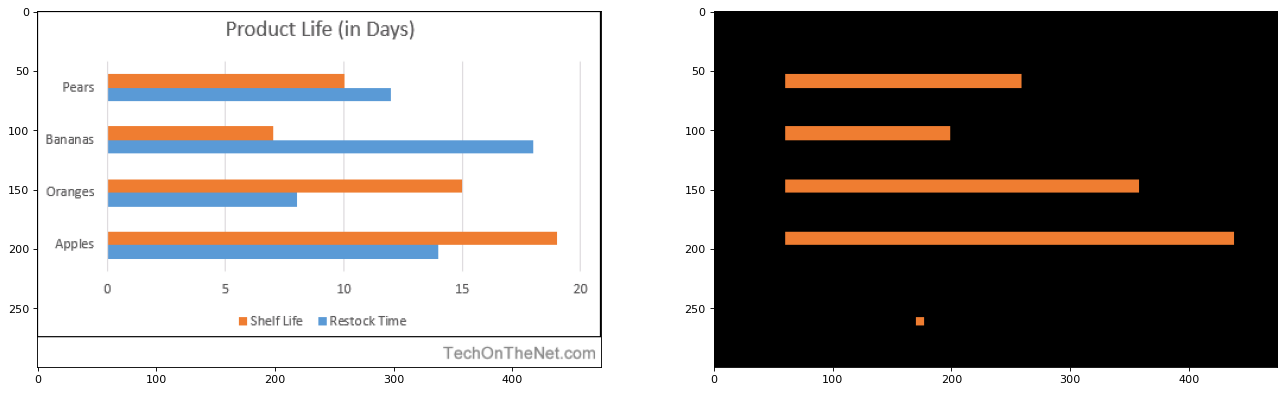

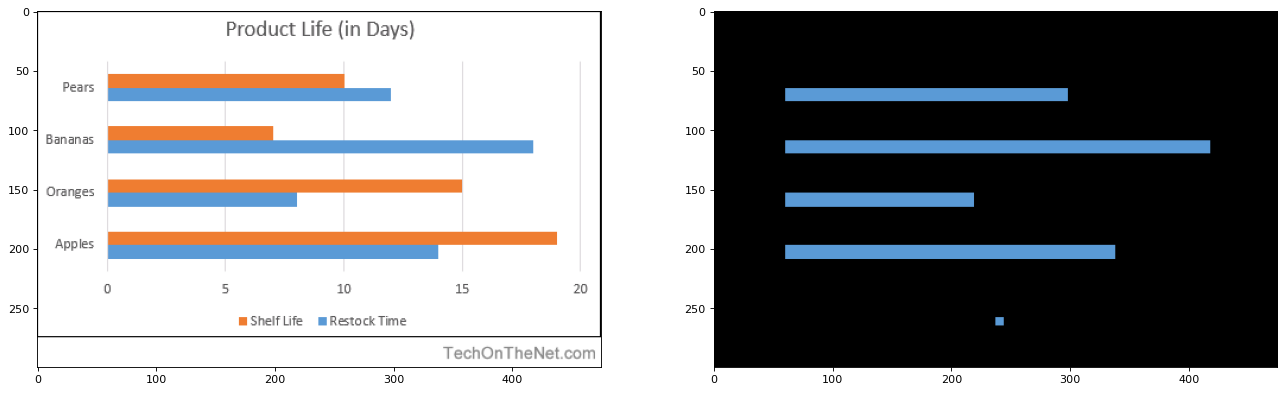

In [63]:
def color_separation(original_img, lowerb, upperb):
    # convert to HSV
    img_hsv = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lowerb, upperb)  # lower-upper -> 255
    # separate color with mask
    img_masked = cv2.bitwise_and(original_img, original_img, mask=mask)
    return img_masked


# orange_lowerb = np.array([108, 178, 224])  # 224,131,68
# orange_upperb = np.array([120,191,255]) 
orange_lowerb = np.array([90,139,235])  
orange_upperb = np.array([110,255,255])  

blue_lowerb = np.array([10,127,190])  # 105,152,209
blue_upperb = np.array([80,207,255])

img_orange = color_separation(original_img, orange_lowerb, orange_upperb)
img_blue = color_separation(original_img, blue_lowerb, blue_upperb)

Image_show(original_img, img_orange)
Image_show(original_img, img_blue)

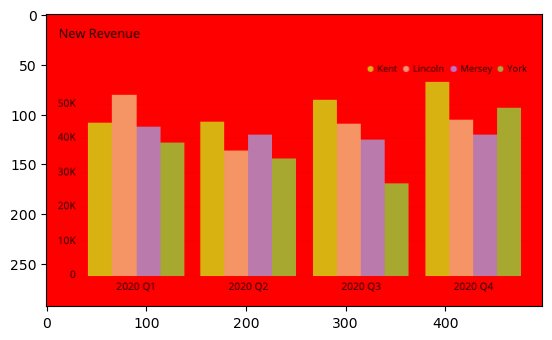

In [66]:
# img_hsv = cv2.cvtColor(original_img, cv2.COLOR_RGB2HSV)
# mask = cv2.inRange(img_hsv, blue_lowerb, blue_upperb)  # lower-upper -> 255
# plt.imshow(cv2_PIL(img_hsv))

ic| contour_name_list: ['contour_Shelf Life', 'contour_Restock Time']


['contour_Shelf Life', 'contour_Restock Time']

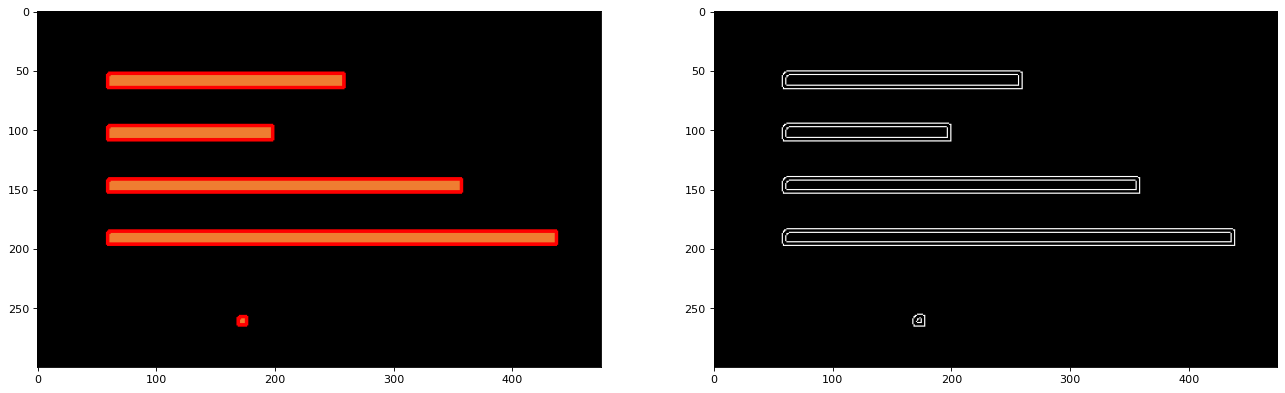

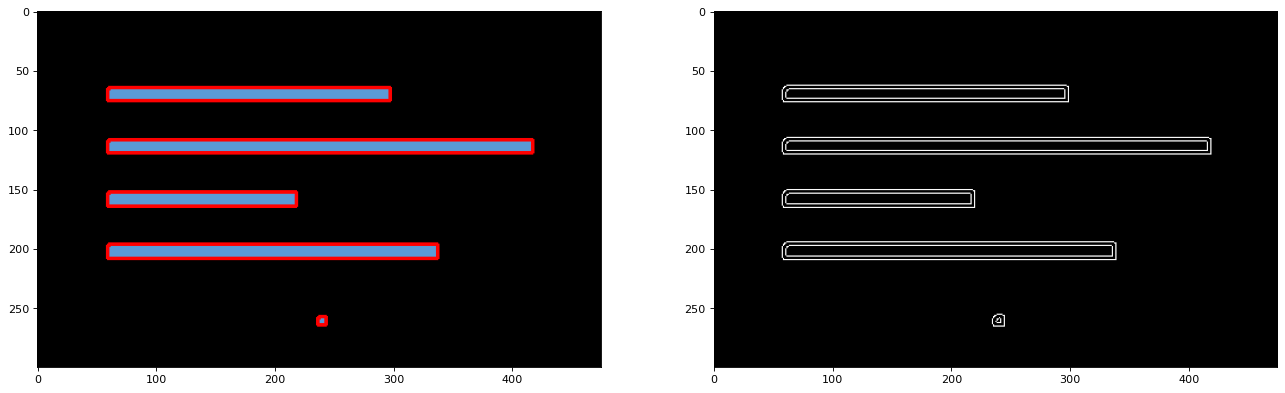

In [88]:
img_color = [img_orange, img_blue]

def find_contour(image):
    edges = cv2.Canny(image, 50, 200)
    # _, edges = cv2.threshold(gray, 150, 200, cv2.THRESH_BINARY)  # apply binary thresholding
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return edges, contours


contour_name_list= []
contour_list= []
edge_list= []

for l, c in list(zip(legend, img_color)):
    edge = 'edge_' + l
    contour = 'contour_' + l
    contour_name_list.append(contour)
    edge, contour =  find_contour(c)
    contour_list.append(contour)
    edge_list.append(edge)
    Image_show(c, edge)
ic(contour_name_list)

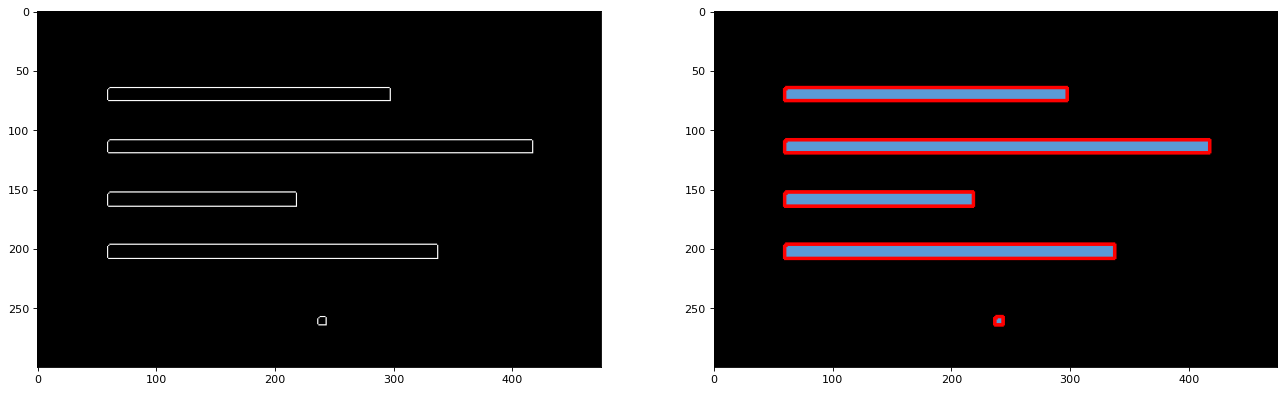

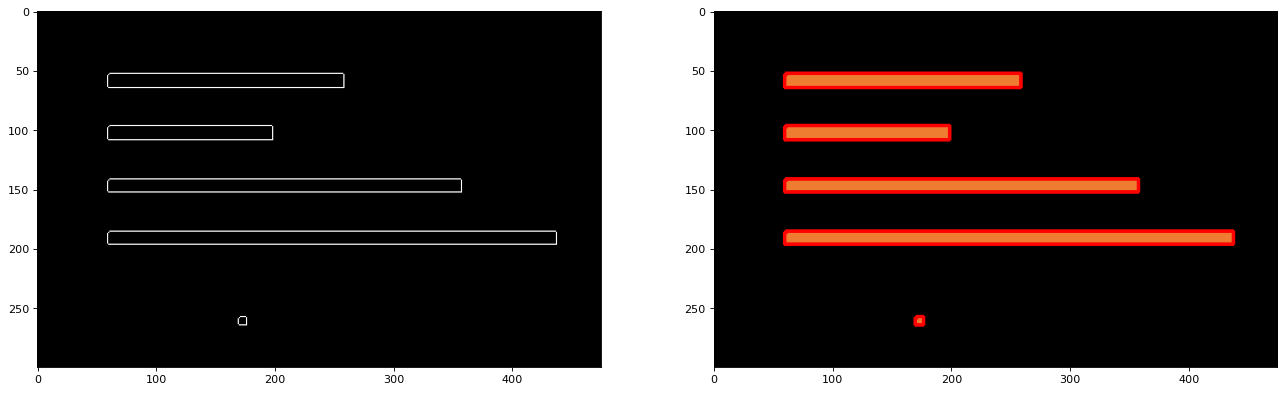

In [65]:
# draw the red contours
for ic, cl, el in list(zip(img_color, contour_list, edge_list)):
    tmp = cv2.drawContours(ic, cl, -1, (0,0,255), 2)  
    Image_show(el, tmp)

## Calculate real y-axis value based on proportion

### Finding legend

In [66]:
def current_legend(contours):
    legend_lower = max(set(legend_top_pixel.tolist()), key=legend_top_pixel.tolist().count)
    legend_upper = legend_top_pixel + legend_h_pixel
    legend_upper = max(set(legend_upper.tolist()), key=legend_top_pixel.tolist().count)

    legend_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if legend_lower <= j[0][1] <= legend_upper:
                legend_dic[j[0][0]].append(j[0][1])

    legend_max = max(legend_dic.keys())
    idx = np.argmin(np.absolute(legend_max - legend_left_pixel))
    cur_legend = legend[idx]
    return cur_legend

cur_legend = current_legend(contour_list[0])
cur_legend

'mRestockTime'

### Diskrete output value of y

get each y axis tick range

In [98]:
# get y-axis minimum and maximum
tmp = []
for i in contour_list[0]:
    for j in i:
        if j[0][1] < legend_top_pixel:
            tmp.append(j[0][1])
y_axis_min = min(tmp)

tmp = []
for i in contour_list[len(legend)-1]:
    for j in i:
        if j[0][1] < legend_top_pixel:
            tmp.append(j[0][1])
y_axis_max = max(tmp)

ic(y_axis_min, y_axis_max)

ic| y_axis_min: 50, y_axis_max: 209


(50, 209)

In [101]:
y_axis_range = []
for i in np.linspace(y_axis_min, y_axis_max, len(y_axis)+1):
    y_axis_range.append(i)
y_axis_range

[50.0, 89.75, 129.5, 169.25, 209.0]

calculating the real y-axis value corresponding to each x-axis

y = (y_pixel_max - x_y_value) / (y_pixel_max - y_pixel_min) * y_axis_max


In [151]:
x_axis_value_dis = []
x_axis_max = int(x_axis[-1])


def discrete(contour_list):
    for cl in contour_list:
        x_axis_value_dis_single = []
        for idx in range(len(y_axis)):
            x_dic = defaultdict(list)
            # operate for each legend
            for i in cl:
                for j in i:
                    if y_axis_range[idx] <= j[0][1] <= y_axis_range[idx+1]:
                        x_dic[j[0][1]].append(j[0][0])
            # find the y-axis value with the highest number of occurrences
            count_pixel = Counter([v for sub_list in x_dic.values() for v in sub_list])
            x_value = max(count_pixel, key=count_pixel.get)
            x_axis_value_dis_single.append(x_value)
            # ic(y_axis_value_dis_single)
        x_axis_value_dis.append(x_axis_value_dis_single)


    x_axis_value = []
    for i in x_axis_value_dis:
        x = (i - x_pixel_min) / (x_pixel_max - x_pixel_min) * x_axis_max
        x = np.round(x, 2)
        x_axis_value.append(x)
    
    return x_axis_value


x_axis_value = discrete(contour_list)
x_axis_value

[array([10.02,  7.01, 14.98, 19.  ]), array([11.97, 17.99,  8.01, 13.98])]

In [136]:
df_dis = pd.DataFrame(np.transpose(x_axis_value), index=y_axis, columns=legend)
df_dis

,Shelf Life,Restock Time
Pears,10.02,11.97
Bananas,7.01,17.99
Oranges,14.98,8.01
Apples,19.00,13.98


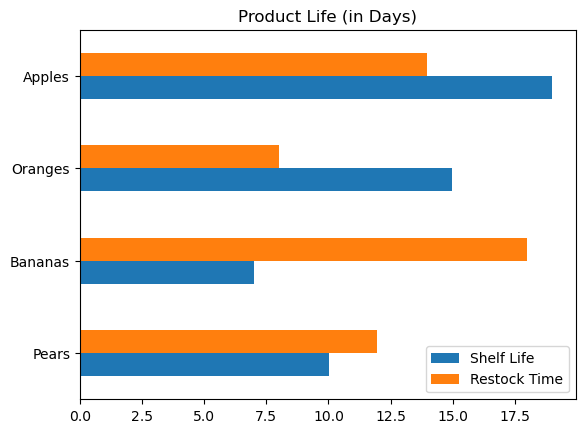

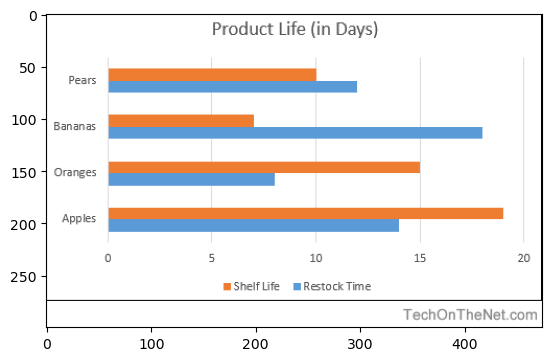

In [137]:
df_dis.plot(kind='barh', stacked=False, title=title)
plt.show()

plt.imshow(img1)

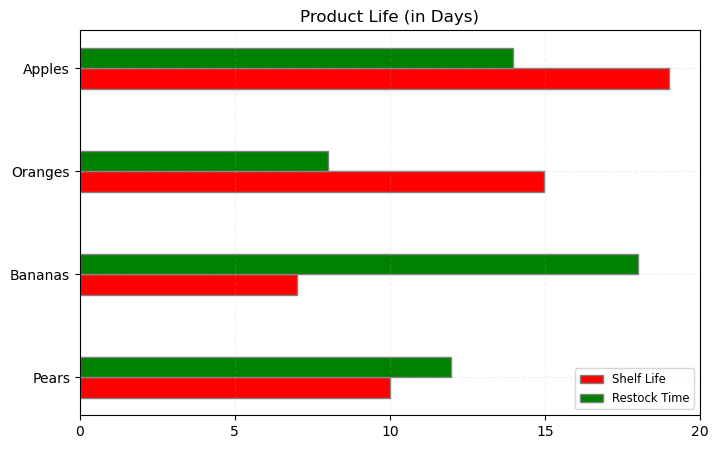

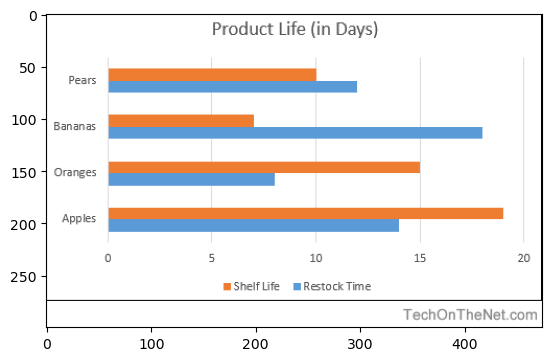

In [147]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(8, 5))
# Set position of bar on X axis
br1 = np.arange(len(x_axis_value[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.barh(br1, x_axis_value[0], color ='r', height = barWidth,
        edgecolor ='grey', label=legend[0])
plt.barh(br2, x_axis_value[1], color ='g', height = barWidth,
        edgecolor ='grey', label=legend[1])

# Adding Xticks
# plt.xlabel('Quarter', fontweight ='bold', fontsize = 15)
# plt.ylabel(title, fontweight ='bold', fontsize = 15)
plt.yticks([r + 0.5*barWidth for r in range(len(x_axis_value[0]))], y_axis)
plt.xticks([r for r in range(int(x_axis[0]), int(x_axis[-1])+1, len(x_axis))], x_axis)
 
plt.title(title)
plt.legend(loc='best', fontsize='small')
plt.grid(linestyle='--', alpha=0.2)
plt.show()

plt.imshow(img1)

reverse the table in order to compare

In [155]:
x_axis_value_rev = []
for i in x_axis_value[::-1]:
    x_axis_value_rev.append(i[::-1]) 

df_dis_rev = pd.DataFrame(np.transpose(x_axis_value_rev), index=y_axis[::-1], columns=legend[::-1])
df_dis_rev

,Restock Time,Shelf Life
Apples,13.98,19.00
Oranges,8.01,14.98
Bananas,17.99,7.01
Pears,11.97,10.02


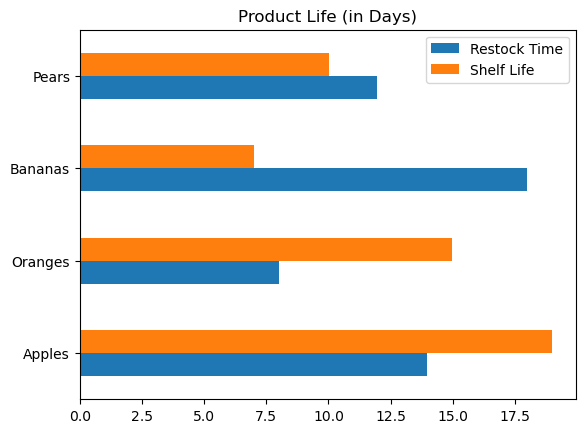

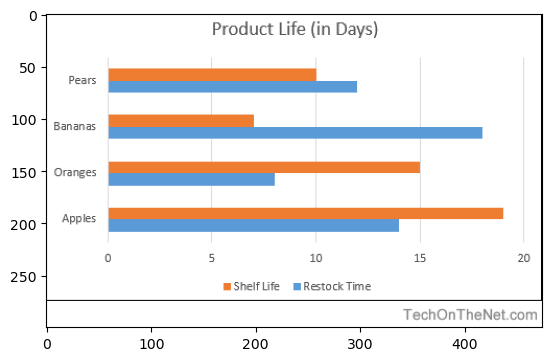

In [156]:
df_dis_rev.plot(kind='barh', stacked=False, title=title)
plt.show()

plt.imshow(img1)

### Continuous output value of y

In [143]:
# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
# y_axis_max = int(y_axis[0])
y_axis_max = float(y_axis[0].strip('%')) / 100.0 
y_axis_max

0.8

In [144]:
def continuous(contours):
    y_dic = defaultdict(list)
    for i in contours:
        for j in i:
            if x_real_pixel[0] <= j[0][0] <= x_real_pixel[-1] and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                y_dic[j[0][0]].append(j[0][1])

    x_y_value = sorted(y_dic.items(), key=lambda x:x[0])

    x_y_value_mean = []
    x_axis_con = []
    for i in x_y_value:
        x, y = i
        # y_mean = statistics.mean(y)
        y_mean = np.mean(y)
        # y_mean = max(set(y),key=y.count)

        x_y_value_mean.append(y_mean)
        x_axis_con.append(x)

    y_axis_value = []
    for i in x_y_value_mean:
        y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
        # y = round(y, 2)
        y = round(y, 6)
        y_axis_value.append(y)

    return x_axis_con, y_axis_value

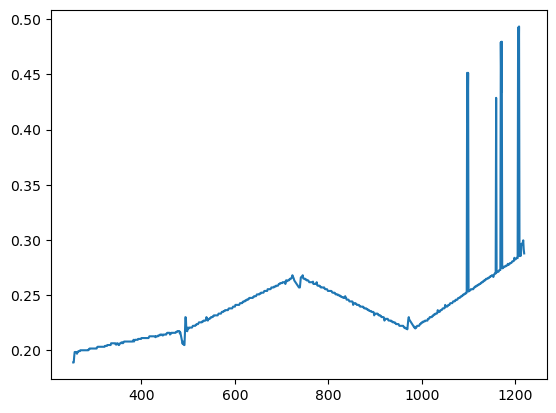

In [147]:
red_lowerb = np.array([110,110,190])  # very clear: 110,50,50
red_upperb = np.array([210,220,250])  # very clear: 230,200,190
yellow_lowerb = np.array([90,150,220])
yellow_upperb = np.array([200,255,255])

img_red = color_separation(original_img, red_lowerb, red_upperb)
edges, contours = find_contour(img_red)
x_axis_con, y_axis_value = continuous(contours)
cur_legend = current_legend(contours)
plt.plot(x_axis_con, y_axis_value)

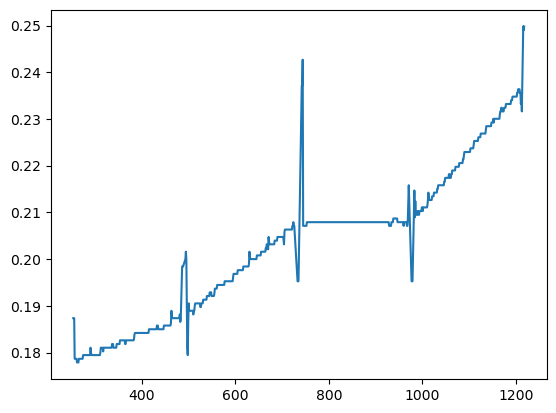

In [148]:
img_red = color_separation(original_img, yellow_lowerb, yellow_upperb)
edges, contours = find_contour(img_red)
x_axis_con1, y_axis_value1 = continuous(contours)
cur_legend1 = current_legend(contours)
plt.plot(x_axis_con1, y_axis_value1)

In [149]:
# change time
def x_axis_change(x_axis_con, x_real_pixel, x_axis):
    x_axis_con_t = []
    for i, m in enumerate(x_axis_con):
        if x_real_pixel[0] <= m < x_real_pixel[1]:
            time = x_axis[0] + '_' + str(m)
        elif x_real_pixel[1] <= m < x_real_pixel[2]:
            time = x_axis[1] + '_' + str(m)
        elif x_real_pixel[2] <= m < x_real_pixel[3]:
            time = x_axis[2] + '_' + str(m)
        elif x_real_pixel[3] <= m < x_real_pixel[4]:
            time = x_axis[3] + '_' + str(m)
        else:
            time = x_axis[4] + '_' + str(m)
        x_axis_con_t.append(time) 

    return x_axis_con_t

x_axis_con_t = x_axis_change(x_axis_con, x_real_pixel, x_axis)
x_axis_con_t1 = x_axis_change(x_axis_con1, x_real_pixel, x_axis)

In [154]:
dat = {'time': x_axis_con_t, cur_legend: y_axis_value}
da = pd.DataFrame(dat)
da

,time,Linkedin
0,2012_254,0.188933
1,2012_255,0.188933
2,2012_256,0.194353
3,2012_257,0.198419
4,2012_258,0.198419
...,...,...
936,2015_1214,0.296443
937,2015_1215,0.295652
938,2015_1217,0.299605
939,2015_1218,0.291700


In [155]:
dat1 = {'time': x_axis_con_t1, cur_legend1: y_axis_value1}
da1 = pd.DataFrame(dat1)
da1

,time,Twitter
0,2012_253,0.187352
1,2012_254,0.187352
2,2012_255,0.187352
3,2012_256,0.178656
4,2012_257,0.178656
...,...,...
931,2015_1212,0.234783
932,2015_1213,0.231621
933,2015_1216,0.249802
934,2015_1217,0.249012


In [156]:
pd.merge(da, da1, on='time', how='inner')

,time,Linkedin,Twitter
0,2012_254,0.188933,0.187352
1,2012_255,0.188933,0.187352
2,2012_256,0.194353,0.178656
3,2012_257,0.198419,0.178656
4,2012_258,0.198419,0.178656
...,...,...,...
920,2015_1211,0.285375,0.233202
921,2015_1212,0.285827,0.234783
922,2015_1213,0.296443,0.231621
923,2015_1217,0.299605,0.249012


## Deleting unusual value (or outliers)

### Standard Deviation Method

In [ ]:
# calculate summary statistics
data_mean, data_std = np.mean(y_axis_value), np.std(y_axis_value)

# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

# identify outliers
outliers = [x for x in y_axis_value if x < lower or x > upper]
# remove outliers
outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
ic(len(outliers), len(outliers_removed))

ic| len(outliers): 10, len(outliers_removed): 931


(10, 931)

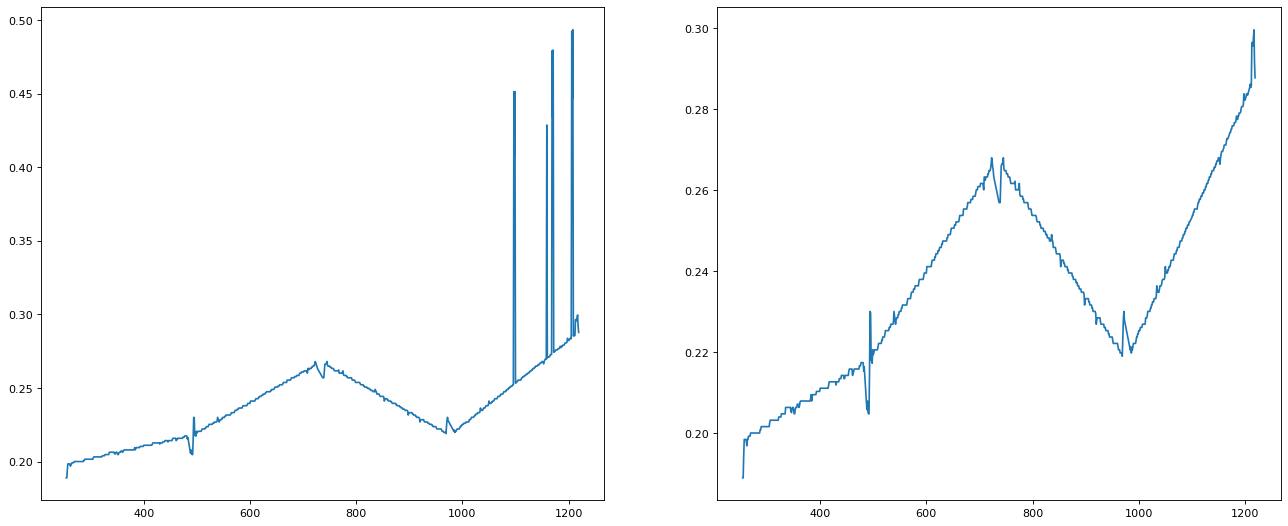

In [ ]:
dat = {'time': x_axis_con, 'yellow':y_axis_value}
data = pd.DataFrame(dat)

df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

### Interquartile Range Method

In [ ]:
# calculate interquartile range
q25, q75 = np.percentile(y_axis_value, 25), np.percentile(y_axis_value, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr *1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in y_axis_value if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.217, 75th=0.255, IQR=0.037
Identified outliers: 10
Non-outlier observations: 931


In [ ]:
def iqr(y_axis_value):
    # calculate interquartile range
    q25, q75 = np.percentile(y_axis_value, 25), np.percentile(y_axis_value, 75)
    iqr = q75 - q25
    # print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outliers = [x for x in y_axis_value if x < lower or x > upper]
    # print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in y_axis_value if x >= lower and x <= upper]
    # print('Non-outlier observations: %d' % len(outliers_removed))

    return outliers_removed

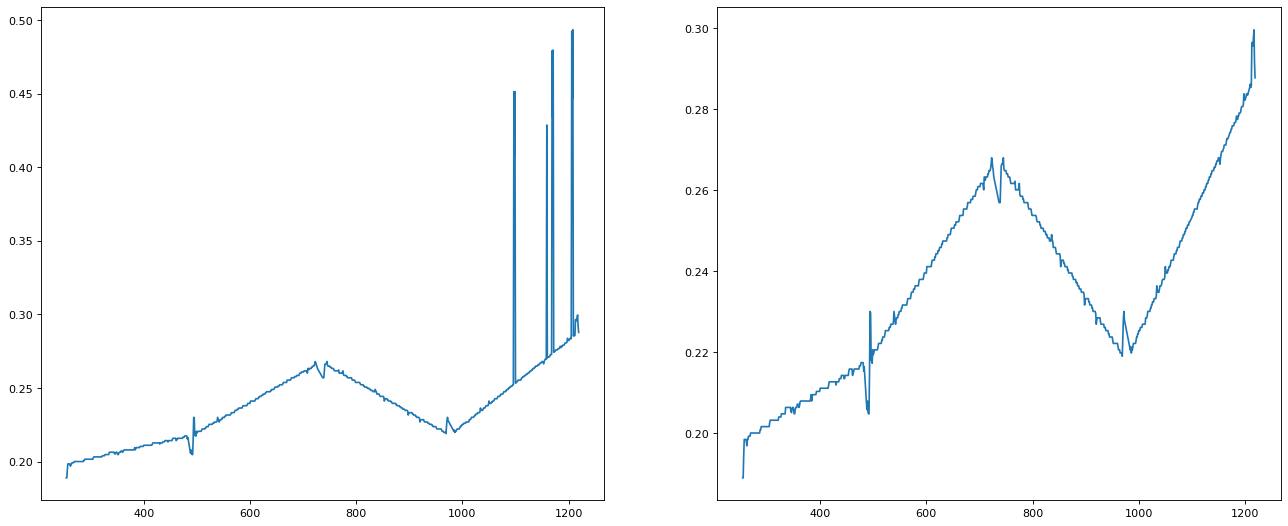

In [ ]:
dat = {'time': x_axis_con, 'yellow':y_axis_value}
data = pd.DataFrame(dat)

df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)

### Sliding window

In [ ]:
outliers_removed = []
len_window = 40
for i in range((len(y_axis_value) // len_window) + 1):
    window_outliers_removed = iqr(y_axis_value[len_window*i : len_window*(i+1)])
    outliers_removed.append(window_outliers_removed)

ic(len(outliers_removed))
outliers_removed = [item for sub_list in outliers_removed for item in sub_list]
ic(len(outliers_removed))

ic| len(outliers_removed): 24
ic| len(outliers_removed): 918


918

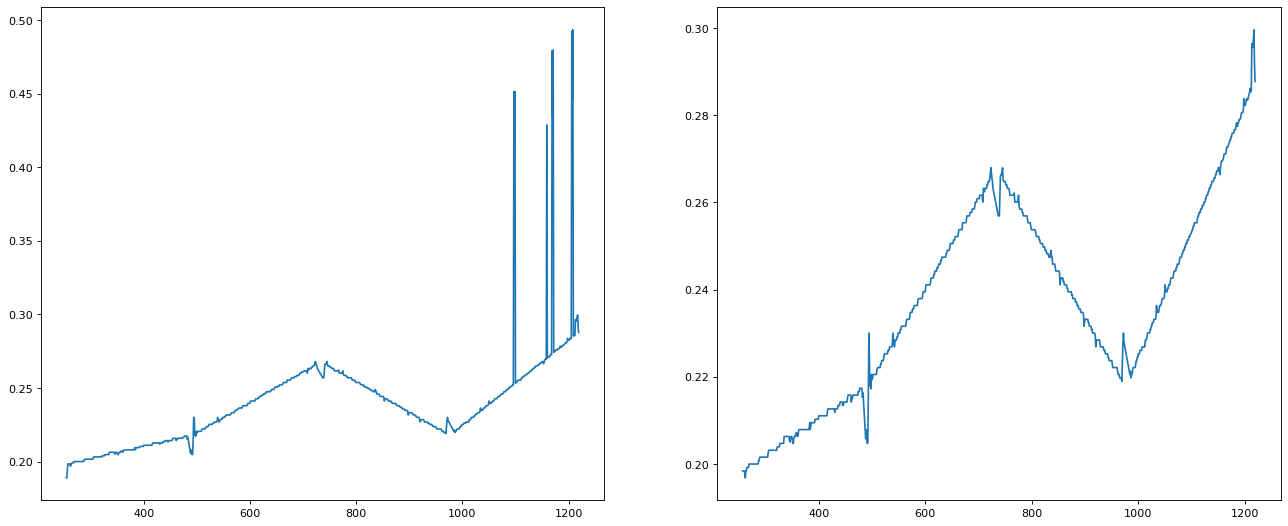

In [ ]:
df_outliers_removed = data[data.yellow.isin(outliers_removed)]
x_outliers_removed = df_outliers_removed.time.values
y_outliers_removed = df_outliers_removed.yellow.values

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].plot(x_axis_con, y_axis_value)
ax[1].plot(x_outliers_removed, y_outliers_removed)